<a href="https://colab.research.google.com/github/xelanac/metagenomic-project/blob/main/metagenomic_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import delle librerie

In [1]:
%%capture
!pip3 install google-nucleus==0.4.0
!pip install -q tensorflow==2.0.0-alpha0

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random

import numpy as np

#librerie per la lettura dei file fastq
from nucleus.io import fastq
from nucleus.io import fasta
from nucleus.io import sam
from nucleus.io import vcf
from nucleus.io.genomics_writer import TFRecordWriter
from nucleus.protos import reads_pb2
from nucleus.util import cigar
from nucleus.util import ranges
from nucleus.util import utils

import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#matplotlib per il plot dell'accuratezza del modello in base ad ogni epoca
import matplotlib.pyplot as plt

#librerie per la creazione del vocabolario
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#librerie per la costruzione della rete neurale RNN
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#Generazione di dataset randomici

In [70]:
bases_list = ["A","C","G","T"]
seq_length = 20 #lunghezza stringa
seq_num = 50 #lunghezza dataset

dna_not_sanitized = []
dna_sanitized = []

In [71]:
def random_seq_generation(n_seq, seq_len, dataset):
  for index in range(n_seq):
    sequence = [random.choice(bases_list) for _ in range(seq_len)]
    sequence = "".join(sequence)
    dataset.append(sequence)

In [72]:
random_seq_generation(seq_num, seq_length, dna_not_sanitized)
random_seq_generation(seq_num, seq_length, dna_sanitized)

#Caricamento e analisi di dati reali (in questo caso trascurare la precedente sezione di generazione di dataset randomici)

Collegamento al drive e import dei dati reali

In [ ]:
#accesso al drive
"""
from google.colab import drive
drive.mount('/content/drive')
"""

In [ ]:
path_not_sanitized = "/content/drive/MyDrive/fastQ_data/fastQ_01_2021/ERX149279.fastq.gz"
path_sanitized = "/content/drive/MyDrive/fastQ_data/fastQ_01_2021/ERX149293.fastq.gz"

In [ ]:
def seq_isolation(dataset, dataset_len, seq_dataset):
  index = 0
  seq_list = []

  for i in dataset:
    if index < dataset_len:
      seq_list.append(i)
      b = str(list(seq_list)[index]).split("\n")[2]
      seq = ""
      for j in b:
        if j == "A" or j == "C" or j == "G" or j == "T":
          seq += j
      seq_dataset.append(seq)
      index += 1
    else:
      break;

In [ ]:
dataset_length = 50 #se non si usa questo flag l'iterazione sul fastq restituisce: "Failed to parse FASTQ record"  

Creazione della lista contenente solo le sequenze dei due fastq

In [ ]:
#lista dna non sanificato -> dna_not_sanitized
fastq_dataset_not_sanitized = fastq.FastqReader(path_not_sanitized)

dna_not_sanitized = []
seq_isolation(fastq_dataset_not_sanitized, dataset_length, dna_not_sanitized)

In [ ]:
#lista dna sanificato -> dna_sanitized
fastq_dataset_sanitized = fastq.FastqReader(path_sanitized)

dna_sanitized = []
seq_isolation(fastq_dataset_sanitized, dataset_length, dna_sanitized)

Check sulla lunghezza delle sequenze

In [ ]:
#Lunghezza massima e minima del dataset "not_sanitized"
print("Lunghezza massima delle sequenze dna_not_sanitized: " , len(max(dna_not_sanitized, key=len)))
print("Lunghezza minima delle sequenze dna_not_sanitized: " , len(min(dna_not_sanitized, key=len)), "\n")

#Lunghezza massima e minima del dataset "sanitized"
print("Lunghezza massima delle sequenze dna_sanitized: " ,  len(max(dna_sanitized, key=len)))
print("Lunghezza minima delle sequenze dna_sanitized: " , len(min(dna_sanitized, key=len)))

Lunghezza massima delle sequenze dna_not_sanitized:  76
Lunghezza minima delle sequenze dna_not_sanitized:  76 

Lunghezza massima delle sequenze dna_sanitized:  76
Lunghezza minima delle sequenze dna_sanitized:  76


Check che verifica se la sequenza ha qualche parametro "K", il quale indica un'imprecisione in fase di campionamento

In [ ]:
def sequences_check(sequences_list):
  i = 0

  for single_sequence in sequences_list:
    for index in single_sequence:
      if index == "K":
        return True
    i+= 1
  return False
  
print("Check delle sequenze non sanificate: \n", sequences_check(dna_not_sanitized))
print("Check delle sequenze  sanificate: \n", sequences_check(dna_sanitized))

Check delle sequenze non sanificate: 
 False
Check delle sequenze  sanificate: 
 False


Se la funzione "sequence_check()" restituisce "True" per una delle due liste, procedere con la correzione; altrimenti procedere con la creazione del vocabolario

In [ ]:
#con questo metodo sostituisco il parametro "k" con una delle basi azotate(in questo caso ho scelto l'Adenina)
def sequences_correction(sequences_list): 
  j = 0
  new_dna_sequence_list = []
  for single_sequence in sequences_list:
    i = 0
    new_sequence = ""
    for index in single_sequence:
      if index == "K":
        new_sequence+="A"
      else:
        new_sequence+=index
      i+=1
    new_dna_sequence_list.append(new_sequence)  
    j+=1     

  sequences_list = new_dna_sequence_list
  return sequences_list

In [ ]:
sequences_correction(dna_not_sanitized)
sequences_correction(dna_sanitized)

#Creo il vocabolario

In [73]:
tokenizer = Tokenizer(char_level=True)

tokenizer.fit_on_texts(dna_not_sanitized)

vocab = tokenizer.word_index
vocab_length = len(vocab) + 1

print("Vocabulary: " ,vocab)

Vocabulary:  {'a': 1, 'c': 2, 't': 3, 'g': 4}


In [74]:
input_not_sanitized = []

for record in dna_not_sanitized:
	token_list = tokenizer.texts_to_sequences([record])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_not_sanitized.append(n_gram_sequence)

#pad sequences 
max_sequence_len = max([len(x) for x in input_not_sanitized])
input_sequences = np.array(pad_sequences(input_not_sanitized, maxlen=max_sequence_len, padding='pre'))

#xs, labels_x = input_sequences[:,:-1],input_sequences[:,-1] #il -1 omette l'ultimo carattere
xs = input_sequences[:,:-1] #il -1 omette l'ultimo carattere

In [75]:
print(input_sequences)
print(input_sequences[:-1])

[[0 0 0 ... 0 2 3]
 [0 0 0 ... 2 3 4]
 [0 0 0 ... 3 4 4]
 ...
 [0 0 1 ... 4 3 1]
 [0 1 2 ... 3 1 1]
 [1 2 1 ... 1 1 1]]
[[0 0 0 ... 0 2 3]
 [0 0 0 ... 2 3 4]
 [0 0 0 ... 3 4 4]
 ...
 [0 0 0 ... 3 4 3]
 [0 0 1 ... 4 3 1]
 [0 1 2 ... 3 1 1]]


In [76]:
input_sanitized = []

for line in dna_sanitized:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sanitized.append(n_gram_sequence)

#pad sequences
max_sequence_len = max([len(x) for x in input_sanitized])
input_sequences = np.array(pad_sequences(input_sanitized, maxlen=max_sequence_len, padding='pre'))

ys, labels_y = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels_y, num_classes=vocab_length)

#Costruzione del modello Rnn con layer LSTM

##Modello RNN Bidirezionale(LSTM)

**N.B:** Bidirectional fa una copia del layer RNN passatogli come argomento e, attraverso il campo go_backwards, riesce a capovolgere l'input, quindi ad elaborarlo anche in ordine inverso.
Questo apporccio non tiene conto solo delle parole successive da generare, ma anche del contesto che c'è intorno al carattere/parola successiva al fine di ottere una migliore predizione, preservando più informazioni utili nel tempo.

In [77]:
def bidirectional_rnn(vocab, max_seq_len):
  print("Bidirectional LSTM MODEL")
  model_bidirectional = Sequential(name="metagenomic prediction bidirectional")
  model_bidirectional.add(Embedding(vocab, 110, input_length=max_seq_len, name="input_layer"))
  model_bidirectional.add(Bidirectional(LSTM(150), name="LSTM"))
  model_bidirectional.add(Dense(vocab, activation='softmax', name="output_layer"))

  adam = Adam(lr=0.01)
  model_bidirectional.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model_bidirectional

In [78]:
model_bidirectional = bidirectional_rnn(vocab_length, max_sequence_len-1)
model_bidirectional.summary()

Bidirectional LSTM MODEL
Model: "metagenomic prediction bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Embedding)      (None, 19, 110)           550       
_________________________________________________________________
LSTM (Bidirectional)         (None, 300)               313200    
_________________________________________________________________
output_layer (Dense)         (None, 5)                 1505      
Total params: 315,255
Trainable params: 315,255
Non-trainable params: 0
_________________________________________________________________


##Training del modello bidirezionale

In [79]:
history_bidirectional = model_bidirectional.fit(xs, ys, epochs=40, verbose=1)

Epoch 1/40
950/950 [==============================] - 3s 3ms/sample - loss: 1.4683 - accuracy: 0.2516
Epoch 2/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.3977 - accuracy: 0.2579
Epoch 3/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.3966 - accuracy: 0.2284
Epoch 4/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.3861 - accuracy: 0.2905
Epoch 5/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.3915 - accuracy: 0.2695
Epoch 6/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.4030 - accuracy: 0.2621
Epoch 7/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.3852 - accuracy: 0.2726
Epoch 8/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.3845 - accuracy: 0.2737
Epoch 9/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.3814 - accuracy: 0.2674
Epoch 10/40
950/950 [==============================] - 2s 2ms/sample - loss: 1.371

##Modello RNN Unidirezionale(LSTM)

In [80]:
def unidirectional_rnn(vocab, max_seq_len):
  print("Unidirectional LSTM MODEL")
  model_unidirectional = Sequential(name="metagenomic prediction unidirectional")
  model_unidirectional.add(Embedding(vocab, 110, input_length=max_seq_len, name="input_layer"))
  model_unidirectional.add(LSTM(150, go_backwards=False))
  model_unidirectional.add(Dense(vocab, activation='softmax', name="output_layer"))

  adam = Adam(lr=0.01)
  model_unidirectional.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model_unidirectional

In [81]:
model_unidirectional = unidirectional_rnn(vocab_length, max_sequence_len-1)
model_unidirectional.summary()

Unidirectional LSTM MODEL
Model: "metagenomic prediction unidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Embedding)      (None, 19, 110)           550       
_________________________________________________________________
unified_lstm_8 (UnifiedLSTM) (None, 150)               156600    
_________________________________________________________________
output_layer (Dense)         (None, 5)                 755       
Total params: 157,905
Trainable params: 157,905
Non-trainable params: 0
_________________________________________________________________


##Training del modello unidirezionale

In [82]:
history_unidirectional = model_unidirectional.fit(xs, ys, epochs=40, verbose=1)

Epoch 1/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.4755 - accuracy: 0.2284
Epoch 2/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.4023 - accuracy: 0.2221
Epoch 3/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.3976 - accuracy: 0.2547
Epoch 4/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.3916 - accuracy: 0.2589
Epoch 5/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.3919 - accuracy: 0.2389
Epoch 6/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.3849 - accuracy: 0.2863
Epoch 7/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.3837 - accuracy: 0.2768
Epoch 8/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.3873 - accuracy: 0.2811
Epoch 9/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.3812 - accuracy: 0.2832
Epoch 10/40
950/950 [==============================] - 1s 1ms/sample - loss: 1.379

##Plot curva di Training

In [83]:
def plot_graphs(history, string, name_model):
  title = "Visualizzazione della curva di Training del modello " + name_model
  plt.suptitle(title)
  plt.plot(history.history[string])
  plt.xlabel("Epoche")
  plt.ylabel(ylabel="Accuratezza")
  plt.show()

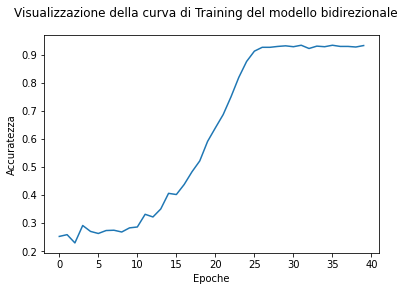

In [84]:
plot_graphs(history_bidirectional, 'accuracy', "bidirezionale")

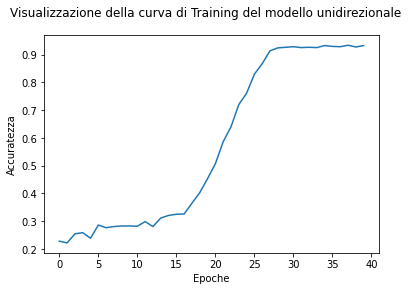

In [85]:
plot_graphs(history_unidirectional, 'accuracy', "unidirezionale")

In [86]:
def make_prediction(next_word_len, tokenizer, model, text_to_predict, j):
	for _ in range(next_word_len):
		token_list = tokenizer.texts_to_sequences([text_to_predict])[0]
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		predicted = model.predict_classes(token_list, verbose=0)
		output_word = ""
		for word, index in tokenizer.word_index.items():
			if index == predicted:
				output_word = word
				break
		text_to_predict += "" + output_word 
		j += "" + output_word 
		new_sequence = "".join(j) #isolo la nuova sequenza generata
	return new_sequence

In [87]:
def make_upper(text, index):
  s = ""
  for i in text:
    if i == "a":
      s = "A"
    if i == "c":
      s = "C"
    if i == "g":
      s = "G"
    if i == "t":
      s = "T"
    index += "" + s
    text = "".join(index)
  return text

## Predizione partendo da metà sequenza non sanificata appartenente al dataset di partenza utilizzato per il training.

In [90]:
#predizione con metà sequenza esistente
existing_dna_seq = dna_not_sanitized[1]
half_seq_length = int(seq_length / 2)


text_to_predict = existing_dna_seq[0:10]
next_words = half_seq_length
new_sequence = []
increase_string = ""

new_sequence = make_prediction(next_words, tokenizer, model_unidirectional, text_to_predict, increase_string)

print(make_upper(new_sequence, "")) #concatenazione tra sequenza passata in input e la nuova generata

TGCGTTCTGC


In [91]:
print("Dna not sanitized in pos 0:" , dna_not_sanitized[1])
print("Dna sanitized in pos 0:    " ,dna_sanitized[1])
print(vocab)

Dna not sanitized in pos 0: TCTCTAGTCACCTAACAGTC
Dna sanitized in pos 0:     GGACCTTTTCTAGCCGTACG
{'a': 1, 'c': 2, 't': 3, 'g': 4}


##Predizione partendo da metà sequenza randomica

In [65]:
#genero metà sequenza di dna non sanificato
half_seq_length = int(seq_length / 2)
half_sequence = [random.choice(bases_list) for _ in range(half_seq_length)]
half_sequence = "".join(half_sequence)

print(half_sequence)

ATGCTTTCTC


In [66]:
text_to_predict = half_sequence
next_words = half_seq_length
new_sequence = []
increase_string = ""

new_sequence = make_prediction(next_words, tokenizer, model_bidirectional, text_to_predict, increase_string)
#new_sequence , text_to_predict = make_prediction(next_words, tokenizer, model, text_to_predict, increase_string)

#print(text_to_predict) #concatenazione tra sequenza passata in input e la nuova generata
print(make_upper(new_sequence,""))

GGAGCAATAG


##Predizione di una sequenza costituita da 440 caratteri.

 Come si procede? Si scompone la sequenza lunga 440 in 44 sottosequenze, ognuna lunga 10 caratteri (questo perchè il modello risulta accurato per la predizione di stringhe lunghe 10 caratteri); poi per ognuna si genera la sequenza sanificata; infine si costruisce la sequenza finale tenendo conto dell'ordine di partenza relativo alle sottosequenze.
 

In [38]:
rnd_max_len = 440
sub_seq_len = 10
n_sub_seq = 44
not_sanitized_max = []
sub_seq_data = []

random_seq_generation(1, rnd_max_len, not_sanitized_max)

In [39]:
sequence = not_sanitized_max[0]

In [40]:
#grazie a questa funzione si riesce a dividere l'intera sequenza di lunghezza 440 in 44 sottosequenze, ognuna di 10 caratteri; si crea, quindi, una lista di sottosequenze
def sub_seq_data_generator(entire_sequence, sub_len, n_sub_seq):
  for i in range(n_sub_seq):
    sub_seq = entire_sequence[i*sub_len:(i+1)*sub_len]
    sub_seq_data.append(sub_seq)

  return sub_seq_data

In [41]:
sub_seq_data = sub_seq_data_generator(sequence, sub_seq_len, n_sub_seq)

In [42]:
sanitized_sub_seq_data = []
increase_sequence = ""

for i in range(n_sub_seq):
  sanitized_sub_seq_data.append(make_prediction(next_words, tokenizer, model_bidirectional, sub_seq_data[i], increase_sequence))

In [43]:
sanitized_max = ""

for i in range(n_sub_seq):
  sanitized_max += sanitized_sub_seq_data[i]

In [44]:
print("Sequenza sanificata    : " , make_upper(sanitized_max, ""))
print("Sequenza non sanificata: " , sequence)

Sequenza sanificata    :  ACCGGCTCAGGGATGCTTTGTATTATTAGTGGGCTATCTTGGGTTGGCATTTCAGCAGCATCAATTAAGTATAATAATGACGGATGGGGCCGAATTAGGGGCATGCTATCCGAAGCGGATGCATGGCATCTGGGGCTTTTAGATAGATAGATGCGTCAGCGGGCAGCATCGGTTCTGCAAGTTTTTTTTGCGGGTGCCAACATCGGACGTAGAGATCGTATCGAATCGGATAGCATGTTGTCATGGCATCGGGTTGACATCATCGGATAGAGGGCACATCTCGCATCTTTGGTGCACCCTGCAACGTGGGTTATTATTAAAGCATCGGATGAGATAGAGATAGATAGAGAAGCGAAAGCTGGTGCTTTTTCAGCATCGTCTTTCTGTAATGGGGGGCGAAGCGCACTATTGACTTTACAAGATAAGCAGAGTTGGACATC
Sequenza non sanificata:  TGGTGAGGGCATATTGTTCCGGAAACTAATCCGTACAATAATATGCGGATCTGTCATAGGGCCGGAGTAAGCAGTATATGGGATACCCATTGGTGGGGGGATGGACATAACACCCTGAGTTGTCTCCGTAACTCTTTGTTAGAGATTTGATTCGATGAGCGCTCGTTCTTGCTGCCTATACCAATCTTAAGTCTACCTATTAGTGCGGGTCGTGGTTATTCCGGCTGACGCTCTTAAGCGTTGAAAAGACGGGAATTCATGTGGTCGTCGAAGCTGTCGTCCTGCTAGCGAATGCCAAGCGGCTTTCTGGGTAAGATCTAGGCCCGGCTCGGGTATTATATGTGATGGTAACGTGGTCTCTGGCATTTAACCCCAGCCCGGTCTACGGACCTAGGGTTTTTGGACAAGTGATGACGGGTTGACTTCATTTTTCTACATGG
